### Convolução usando Pytorch

Veremos em detalhe como realizar convolução usando Pytorch e como funciona a camada convolucional

In [2]:
import torch
import torch.nn.functional as F
from torch import nn

# Sinal
x = torch.tensor([5, 4, 8, 7, 9, 3, 6], dtype=torch.float32)
# Filtro
weight = torch.tensor([1, 2, 3], dtype=torch.float32)
# Tamanho do filtro
ks = len(weight)

# Redimensiona o sinal para o tamanho 1x1xlen(x). Ou seja, um batch contendo um único sinal, 
# e esse sinal possui um único canal
x = x.reshape(1,1,len(x))
# Redimensiona o filtro. O primeiro valor 1 possui um significado diferente do que
# no caso do sinal. Depois será explicado.
weight = weight.reshape(1,1,len(weight))
# Realiza a convolução
y = F.conv1d(x, weight)

print(y)
print(y.shape)

tensor([[[37., 41., 49., 34., 33.]]])
torch.Size([1, 1, 5])


O tamanho da entrada é 7 e da saída é 5. Isso porque o Pytorch realiza a convolução apenas nas posições que não necessitam de preenchimento de borda. Mas modificar o tamanho do resultado é indesejável. 

É muito comum realizarmos a convolução com padding para manter o tamanho do sinal:

In [3]:
# padding = ks//2 garante que a saída sempre terá o mesmo tamanho que a entrada
y = F.conv1d(x, weight, padding=ks//2)
print(y.shape)

torch.Size([1, 1, 7])


Dado o sinal [5, 4, 8, 7, 9, 3, 6] e filtro [1,2,3], nossa saída deve ser:

* y[0] = 1\*0 + 2\*5 + 3\*4 = 22
* y[1] = 1\*5 + 2\*4 + 3\*8 = 37
* ...
* y[6] = 1\*3 + 2\*6 + 3\*0 = 15

Note que a função realiza a correlação-cruzada, e não a convolução. Mas para redes neurais isso não importa.

In [4]:
print(y)

tensor([[[22., 37., 41., 49., 34., 33., 15.]]])


Em redes neurais a convolução possui o conceito de bias, que é simplesmente um valor constante que é adicionado ao resultado:

In [5]:
bias = torch.tensor([5.])
# Adiciona o valor 5 a cada elemento do resultado da convolução
y_bias = F.conv1d(x, weight, padding=ks//2, bias=bias)
print(y_bias)
print(torch.allclose(y+bias, y_bias))

tensor([[[27., 42., 46., 54., 39., 38., 20.]]])
True


### Camada de convolução

In [6]:
# A entrada terá 1 canal, queremos apenas 1 canal de saída. O tamanho do filtro é ks, o 
# padding é metade do tamanho do filtro e a camada não terá bias
conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=ks, padding=ks//2, bias=False)
y = conv(x)
print(y)

tensor([[[-2.3318, -1.1779, -3.5166, -2.6080, -4.3663, -0.6838, -3.1815]]],
       grad_fn=<ConvolutionBackward0>)


Uma camada de convolução consiste em um filtro possuindo valores aleatórios. Esse filtro possui o parâmetro requires_grad=True por padrão. Podemos alterar os valores do filtro se quisermos:

In [7]:
print(conv.weight.shape)
print(conv.weight)

with torch.no_grad():
    conv.weight[:] = weight

# Mesmo resultado que a convolução que fizemos antes:
conv(x)

torch.Size([1, 1, 3])
Parameter containing:
tensor([[[ 0.0380, -0.5493,  0.1036]]], requires_grad=True)


tensor([[[22., 37., 41., 49., 34., 33., 15.]]], grad_fn=<ConvolutionBackward0>)

### Relação entre convolução e combinação linear

Uma convolução nada mais é do que uma combinação linear com menos parâmetros

In [8]:
# Matriz de convolução. Cada linha representa uma posição do kernel. Por exemplo,
# a linha 0 fará a operação 2*x[0]+3*x[1]+0*x[2]+...
matrix = torch.tensor([[2, 3, 0, 0, 0, 0, 0],
                       [1, 2, 3, 0, 0, 0, 0],
                       [0, 1, 2, 3, 0, 0, 0],
                       [0, 0, 1, 2, 3, 0, 0],
                       [0, 0, 0, 1, 2, 3, 0],
                       [0, 0, 0, 0, 1, 2, 3],
                       [0, 0, 0, 0, 0, 1, 2]], dtype=torch.float32)

F.linear(x, matrix)

tensor([[[22., 37., 41., 49., 34., 33., 15.]]])

Acima temos uma matrix 7x7 que recebe 7 atributos de entrada e gera 7 atributos de saída. Mas a combinação linear dos atributos de entrada sempre envolvem apenas 3 parâmetros.

### Convolução com mais de um canal

In [9]:
# Batch contendo um sinal de tamanho 7 e com 4 canais
x = torch.rand(size=(1,4,7))
# Camada que recebe sinal com 4 canais e gera um sinal com 5 canais.
conv = nn.Conv1d(in_channels=4, out_channels=5, kernel_size=ks, padding=ks//2, bias=False)

y = conv(x)
print("x\n",x)
# Saída possui tamanho 1x5x7
print("y\n",y)

x
 tensor([[[0.0169, 0.9836, 0.4113, 0.2411, 0.2947, 0.4395, 0.4729],
         [0.1641, 0.7425, 0.6500, 0.1439, 0.7097, 0.0430, 0.3125],
         [0.8427, 0.6247, 0.2981, 0.0027, 0.8906, 0.0913, 0.1239],
         [0.9747, 0.7512, 0.7640, 0.1955, 0.5211, 0.6876, 0.3628]]])
y
 tensor([[[-0.0090,  0.0784,  0.0761,  0.4238, -0.1894,  0.1126,  0.0515],
         [ 0.1756, -0.3301, -0.0995, -0.0784, -0.0140, -0.2588, -0.0484],
         [ 0.0301, -0.3720,  0.0824, -0.1092, -0.0713, -0.0804, -0.0375],
         [-0.4228, -0.5119, -0.1289, -0.2826, -0.6415,  0.0203, -0.2004],
         [ 0.4548,  0.4286, -0.0013,  0.1213,  0.0898,  0.2047,  0.0133]]],
       grad_fn=<ConvolutionBackward0>)


* O **número de canais de saída** define o **número de filtros** que serão utilizados na camada de convolução. No nosso caso, temos 5 filtros
* Cada filtro possui **tamanho espacial ks**
* Cada filtro possui **profundidade 4**, pois o sinal de entrada possui 4 canais.
* Portanto, temos 5 filtros de tamanho 4 x ks cada
* Portanto, o tamanho do tensor .weight da camada de convolução possui tamanho 5 x 4 x ks

In [10]:
conv.weight.shape

torch.Size([5, 4, 3])

In [11]:
# Filtro 1 da camada
filtro1 = conv.weight[0]
# Região do sinal que corresponde quando o filtro está na posição 1
regiao = x[0,:,0:3]
# Resultado da convolução para esse ponto específico
res = (filtro1*regiao).sum()
# comparação do resultado
print(torch.allclose(y[0,0,1], res))

True


### Outros parâmetros da convolução

#### Stride
Stride define a quantidade de deslocamento do filtro para cada posição na qual a convolução será calculada

In [12]:
x = torch.tensor([5, 4, 8, 7, 9, 3, 6], dtype=torch.float32)
weight = torch.tensor([1, 2, 3], dtype=torch.float32)
x = x.reshape(1,1,len(x))
weight = weight.reshape(1,1,len(weight))

# Faz o filtro deslocar duas posições ao invés de deslocar uma posição por vez
y = F.conv1d(x, weight, stride=2)
print(y)

tensor([[[37., 49., 33.]]])


In [13]:
# O resultado de stride=2 é equivalente a indexar a saída de stride=1 pulando 2 índices
yt = F.conv1d(x, weight, stride=1)
print(torch.allclose(y, yt[0,0,::2]))

True


#### Dilatação

Dilatação consiste em aumentar o tamanho do filtro sem aumentar o número de parâmetros

In [14]:
y = F.conv1d(x, weight, dilation=2)
print(y)

tensor([[[48., 27., 44.]]])


In [15]:
# dilatação=2 é equivalente a inserir 0 entre os valores do filtro
wt = torch.tensor([1, 0, 2, 0, 3], dtype=torch.float32).reshape(1,1,-1)
yt = F.conv1d(x, wt, dilation=1)
print(torch.allclose(y, yt))

True


### Detecção de padrões usando convolução 

A convolução pode ser utilizada para detectar padrões. Suponha que nos é dado o seguinte sinal:

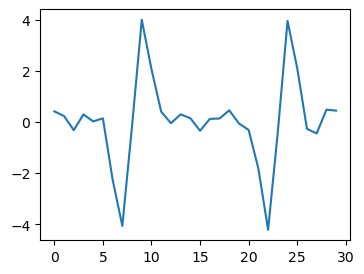

In [122]:
import matplotlib.pyplot as plt
import numpy as np

signal = np.loadtxt("../data/signal.txt")
plt.plot(signal)

Queremos detectar a posição do padrão (-4, 4) que se repete duas vezes no sinal. Podemos desenvolver um filtro que possua esse padrão, e usá-lo em uma operação de convolução:

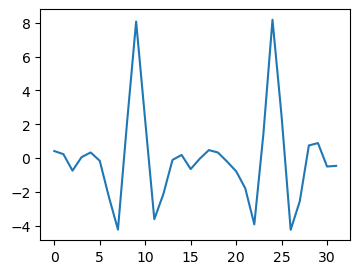

In [123]:
signal = torch.from_numpy(signal).to(torch.float32)
pattern = torch.tensor([-1., 0., 1.])
y = F.conv1d(signal.reshape(1, -1), pattern.reshape(1,1,-1), padding=2)

plt.plot(y[0])

As posições nas quais o filtro possui alta resposta representam a ocorrência do padrão procurado.